Assignemnt 4 Problem statement: https://ovgu-ailab.github.io/idl2020w/ass4.html

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import numpy as np
import matplotlib.pyplot as plt

In [32]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Number of GPUs Available: ",len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

Number of GPUs Available:  1


(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(32, 32, 3)


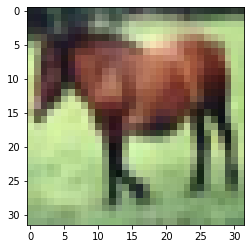

In [33]:
# Load CIFAR Data set.
cifar10 = tf.keras.datasets.cifar10 # tf.keras.datasets.cifar10.load_data()
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(train_images[0].shape)

input_shape = train_images[0].shape
#show the first image.
plt.imshow(train_images[7])

In [34]:
data = tf.data.Dataset.from_tensor_slices(
    (train_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, train_labels.reshape(-1,).astype(np.int32))).batch(64)

test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, test_labels.reshape(-1,).astype(np.int32))).batch(10000)

num_classes = 10

Model: "densenet_model_cifar"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_159 (Conv2D)             (None, 16, 16, 32)   896         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 8, 8, 32)     0           conv2d_159[0][0]                 
__________________________________________________________________________________________________
batch_normalization_156 (BatchN (None, 8, 8, 32)     128         max_pooling2d_3[0][0]            
_______________________________________________________________________________

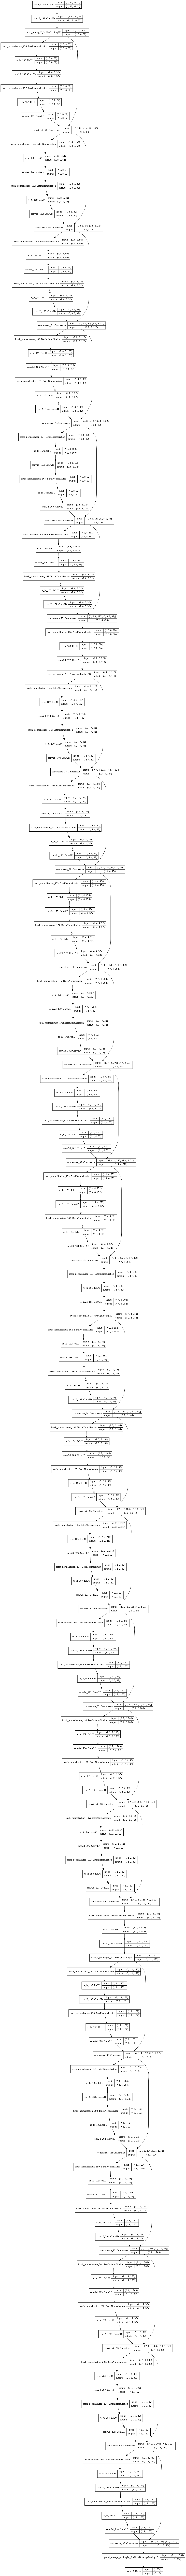

In [35]:
input_img = tf.keras.Input([32,32,3]) # [32,32,3]

#@tf.function#(input_signature=[tf.TensorSpec(shape=[None,32,32,3],dtype=tf.float32),tf.TensorSpec(shape=[],dtype=tf.int32),tf.TensorSpec(shape=[],dtype=tf.int32),tf.TensorSpec(shape=[],dtype=tf.int32)])
def batch_Relu_conv(t,num_filter,filter_size,strides):
  t = tf.keras.layers.BatchNormalization()(t)
  t = tf.keras.layers.ReLU()(t)     
  t = tf.keras.layers.Conv2D(filters=num_filter,kernel_size=(filter_size,filter_size),strides=strides,padding='same')(t)     
  return t

#@tf.function#(input_signature=[tf.TensorSpec(shape=[None,32,32,3],dtype=tf.float32),tf.TensorSpec(shape=[],dtype=tf.int32)])
def transition_layer(t,num_filter):
  t = batch_Relu_conv(t,num_filter,1,1) # 1 * 1 and strides = 1 for conv in transition layer.
  t = tf.keras.layers.AvgPool2D(pool_size=(2,2),strides=2,padding='same')(t)
  return t


#@tf.function#(input_signature=[tf.TensorSpec(shape=[None,32,32,3],dtype=tf.float32),tf.TensorSpec(shape=[],dtype=tf.int32)])
def dense_layer(t,num_blocks):
  for _ in range(num_blocks):
    temp_t = batch_Relu_conv(t,32,1,1)
    new_t = batch_Relu_conv(temp_t,32,3,1)
    t = tf.keras.layers.concatenate([t,new_t])
  return t


#@tf.function
def Generate_dense_Net(input_img,dens_block_rep):
  t = tf.keras.layers.Conv2D(32,(3,3),strides=2,padding='same')(input_img)
  t = tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2),padding='same')(t)
  
  for rep in dens_block_rep:
    d_out = dense_layer(t,rep)
    t = transition_layer(d_out,tf.keras.backend.int_shape(d_out)[-1] // 2)

  t = tf.keras.layers.GlobalAvgPool2D()(d_out)
  output = tf.keras.layers.Dense(num_classes,activation='softmax')(t)

  model = tf.keras.Model(input_img,output,name="densenet_model_cifar")

  return model

#print(input_img)
model = Generate_dense_Net(input_img,[6,6,6,6])
model.summary()
keras.utils.plot_model(model, "dense_net.png", show_shapes=True)






In [36]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

model.fit(x=data,epochs=90,shuffle=True)


Epoch 1/90
782/782 [==============================] - 15s 19ms/step - loss: 2.0534 - sparse_categorical_accuracy: 0.4004
Epoch 2/90
782/782 [==============================] - 15s 19ms/step - loss: 1.9770 - sparse_categorical_accuracy: 0.4800
Epoch 3/90
782/782 [==============================] - 15s 19ms/step - loss: 1.9507 - sparse_categorical_accuracy: 0.5069
Epoch 4/90
782/782 [==============================] - 15s 19ms/step - loss: 1.9270 - sparse_categorical_accuracy: 0.5311
Epoch 5/90
782/782 [==============================] - 15s 19ms/step - loss: 1.9140 - sparse_categorical_accuracy: 0.5443
Epoch 6/90
782/782 [==============================] - 15s 19ms/step - loss: 1.9107 - sparse_categorical_accuracy: 0.5480
Epoch 7/90
782/782 [==============================] - 15s 19ms/step - loss: 1.8879 - sparse_categorical_accuracy: 0.5708
Epoch 8/90
782/782 [==============================] - 15s 19ms/step - loss: 1.8814 - sparse_categorical_accuracy: 0.5773
Epoch 9/90
782/782 [============

In [37]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x=test_data)
print("test loss, test acc:", results)

Evaluate on test data
1/1 [==============================] - 0s 2ms/step - loss: 1.8177 - sparse_categorical_accuracy: 0.6429
test loss, test acc: [1.8177392482757568, 0.6428999900817871]
